This code is used to reformat the data quoted from various papers, 
then compare the pulsar positions from timing and VLBI astrometry.

In [1]:
from functools import reduce

import numpy as np
from numpy import sin, cos, pi, sqrt, concatenate
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import NullLocator

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

from statsmodels.iolib.table import SimpleTable
import seaborn as sns

from psrcrf_tools import *

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

## 1.1 Load the database

Read the timing solution data.

In [2]:
timing_table = Table.read("../data/timing_vlbi.fits",)
timing_table.sort("psr_name")

In [3]:
msp_list = ["J1022+1001", "J2010-1323",
            "J2145-0750", "J2317+1439", "J1012+5307", "J1537+1155"]

In [4]:
for msp_name in msp_list:
    mask = ((timing_table["psr_name"] != msp_name))
    timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [5]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [6]:
vlbi_table = Table.read("../data/psrpi.dat", format="ascii")

Add unit information

In [7]:
vlbi_table["ra"].unit = u.deg
vlbi_table["dec"].unit = u.deg
vlbi_table["pmra"].unit = u.mas / u.yr
vlbi_table["pmdec"].unit = u.mas / u.yr
vlbi_table["plx"].unit = u.mas
vlbi_table["ra_err"].unit = u.mas
vlbi_table["dec_err"].unit = u.mas
vlbi_table["pmra_err"].unit = u.mas / u.yr
vlbi_table["pmdec_err"].unit = u.mas / u.yr
vlbi_table["plx_err"].unit = u.mas

Supplement the timing table with the Gaia astrometrical information.

In [8]:
vlbi_timing = join(timing_table,
                   vlbi_table,
                   keys="psr_name",
                   join_type="left",
                   table_names=["t", "v"])

vlbi_timing.rename_column("pos_epoch_t", "pos_epoch")

count_psr_nb(vlbi_timing)

There are 56 pulsars with 175 measurements.


## 1.2 Comparison of pulsar positions from timing and VLBI

Propagate the VLBI position from its epoch to the timing positonal epoch and compute the positional offset,
in the sense of timing minus VLBI.

In [9]:
# Epoch difference in Julian year
dt_y = (vlbi_timing["pos_epoch"].value -
        vlbi_timing["pos_epoch_v"]) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(vlbi_timing["dec_v"].value))

dra = (vlbi_timing["ra_t"] - vlbi_timing["ra_v"]) * \
    dec_fac - dt_y * vlbi_timing["pmra_v"]

ddec = vlbi_timing["dec_t"] - vlbi_timing[
    "dec_v"] - dt_y * vlbi_timing["pmdec_v"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

vlbi_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [10]:
vlbi_timing["ra_err_t"] = vlbi_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(vlbi_timing["ra_err_v"]**2
                  + vlbi_timing["ra_err_t"]**2
                  + (dt_y*vlbi_timing["pmra_err_v"]).value**2)

ddec_err = np.sqrt(vlbi_timing["dec_err_v"]**2
                   + vlbi_timing["dec_err_t"]**2
                   + (dt_y*vlbi_timing["pmdec_err_v"]).value**2)

vlbi_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

## 1.3 Plot sky distribution of the pulsar sample

In [11]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

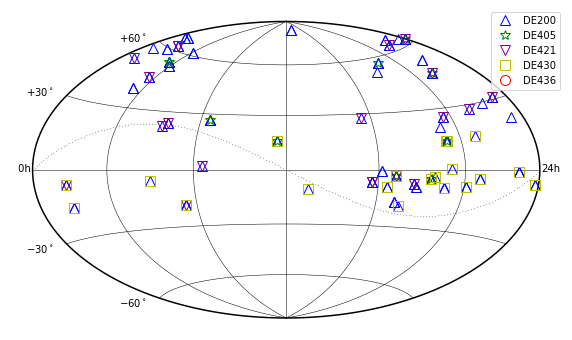

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(vlbi_timing200["ra_v"], vlbi_timing200["dec_v"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(vlbi_timing405["ra_v"], vlbi_timing405["dec_v"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(vlbi_timing421["ra_v"], vlbi_timing421["dec_v"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(vlbi_timing430["ra_v"], vlbi_timing430["dec_v"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(vlbi_timing436["ra_v"], vlbi_timing436["dec_v"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of positional formal uncertainties

In [13]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(vlbi_timing200, ref="v")
pos_err_tab[1, :] = calc_med_pos_err(vlbi_timing405, ref="v")
pos_err_tab[2, :] = calc_med_pos_err(vlbi_timing421, ref="v")
pos_err_tab[3, :] = calc_med_pos_err(vlbi_timing430, ref="v")
pos_err_tab[4, :] = calc_med_pos_err(vlbi_timing436, ref="v")

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 1.5 Remove pulsars near ecliptic plane

In [14]:
mask = (
    (vlbi_timing["psr_name"] != "J0614+2229")
    & (vlbi_timing["psr_name"] != "J0629+2415")
    #     & (vlbi_timing["psr_name"] != "J0826+2637")
    & (vlbi_timing["psr_name"] != "J1022+1001")
    & (vlbi_timing["psr_name"] != "J1257-1027")
    #     & (vlbi_timing["psr_name"] != "J1650-1654")
    & (vlbi_timing["psr_name"] != "J1703-1846")
    #     & (vlbi_timing["psr_name"] != "J2010-1323")
    #     & (vlbi_timing["psr_name"] != "J2145-0750")
    #     & (vlbi_timing["psr_name"] != "J2248-0101")
    & (vlbi_timing["psr_name"] != "J2346-0609")
)

vlbi_timing = Table(vlbi_timing[mask], masked=False)

# 2. Comparison of pulsar positions from timing and VLBI

##  2.1 DE200 vs VLBI

In [15]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

nb_psr_200 = len(vlbi_timing200.group_by("psr_name").groups)
nb_obs_200 = len(vlbi_timing200)
count_psr_nb(vlbi_timing200)

There are 51 pulsars with 106 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:662: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


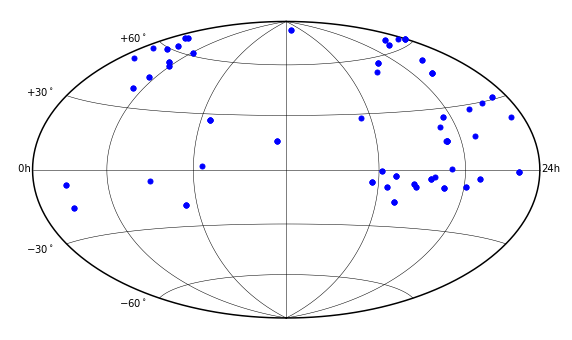

In [16]:
sou_dist_plot(vlbi_timing200["ra_v"], vlbi_timing200["dec_v"])

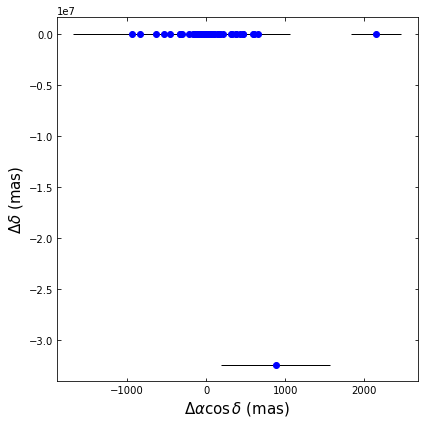

In [17]:
simple_plot(vlbi_timing200)

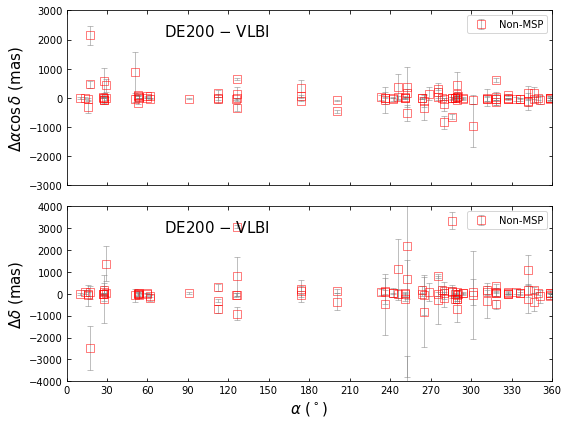

In [18]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-3000, 3000, -4000, 4000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

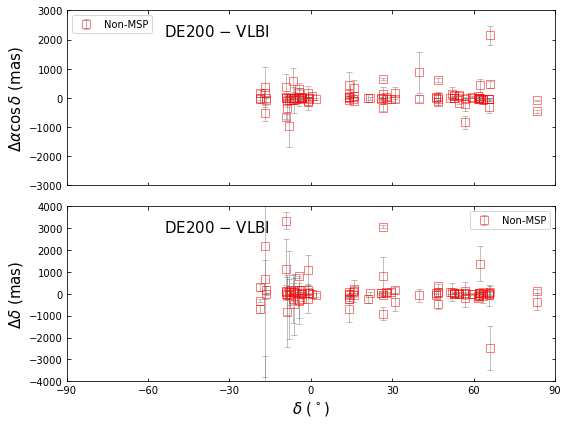

In [19]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-3000, 3000, -4000, 4000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    #                  fig_name="vlbi_pos-oft-vs-dec-de200.eps",
    ref="v",
    xaxis="dec",
    divided=True,
)

In [20]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    vlbi_timing200, ref="v")

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 51 1557760.7 1557751.0    -159.61     146.29     -26.74 J0323+3944    48382 324006439.4
 2 51     16.8     16.7       8.18     -16.19       9.71 J0826+2637    51700   2615.6
 3 51      4.0      3.9     -13.58     -14.71      -8.31 J1901-0906    49901    121.0
 4 51      3.4      3.3     -12.58     -14.80      -7.11 J1820-0427    51700    112.0
 5 51      2.9      2.8     -12.20     -14.92      -8.66 J2113+4644    51700     85.8
 6 51      2.5      2.4     -10.92     -16.12      -9.23 J1321+8323    48383     56.7
 7 51      2.2      2.1      -8.73     -15.50      -8.19 J0108+6608    48464     51.1
 8 51      2.0      1.9      -8.43     -15.51      -8.17 J1321+8323    48889     22.9
 9 50      1.8      1.8      -1.95     -14.15      -5.15 J1917+1353    49763     30.0
10 50      1.7      1.6      -7.57     -17.49     -11.17 J1917+1353    49021     24.4
11 50      1.6      1.5      -8.89     -18.40    

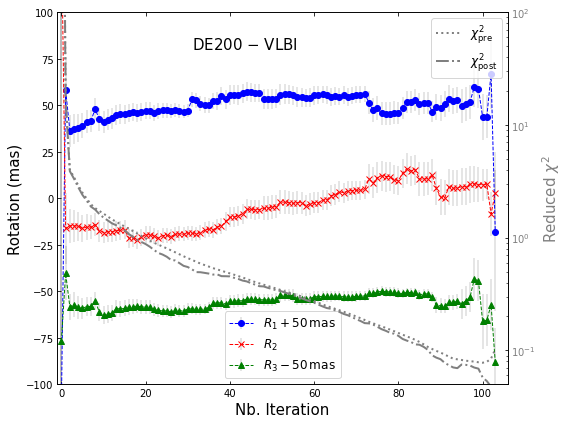

In [21]:
rot_vs_iter(pmt200,
            sig200, [-1, 106, -100, 100],
            elw=0.2,
            add_text=[0.3, 0.9, "DE200 $-$ VLBI"],
            apr_chi2=apr_chi2_200,
            pst_chi2=pst_chi2_200,
            ax_loc="lower center",
            ax1_loc="upper right",
            ax1_ylim=[0.05, 100],
            caps=0, y_shift=50)

In [22]:
rot200, iqr200 = find_pmt_est(pmt200)

dra_200, ddec_200 = calc_dpos(vlbi_timing200, rot200, ref="v")

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(vlbi_timing200, dra_200, ddec_200)

In [23]:
mask = (
    (np.fabs(vlbi_timing200["dra"]) < 1000)
    & (np.fabs(vlbi_timing200["ddec"]) < 1000)
)

vlbi_timing200_a = vlbi_timing200[mask]

In [24]:
nb_psr_200 = len(vlbi_timing200_a.group_by("psr_name").groups)
nb_obs_200 = len(vlbi_timing200_a)

print("After removing outliers, we have", nb_psr_200,
      "pulsars in the sample from DE200 vs. PSRPI comparison with",
      nb_obs_200, "observations.")

After removing outliers, we have 51 pulsars in the sample from DE200 vs. PSRPI comparison with 97 observations.


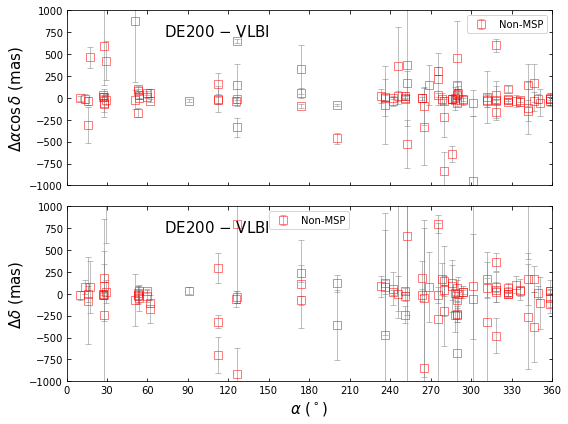

In [25]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-1000, 1000, -1000, 1000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

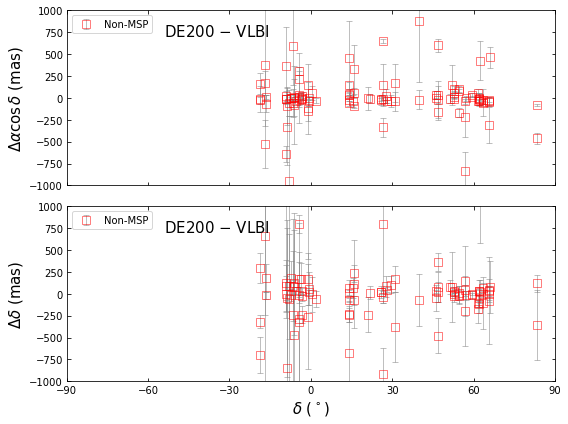

In [26]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-1000, 1000, -1000, 1000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

In [27]:
pmt200_a, sig200_a, indx, apr_chi2_200_a, pst_chi2_200_a = rot_fit_4_table(
    vlbi_timing200_a, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 51      3.3      3.2     -12.20     -14.69      -7.03 J1820-0427    51700    112.0
 2 51      2.7      2.6     -11.82     -14.81      -8.57 J2113+4644    51700     85.8
 3 51      2.3      2.2     -10.54     -16.01      -9.15 J1321+8323    48383     56.8
 4 51      2.0      1.9      -8.35     -15.39      -8.11 J1321+8323    48889     22.9
 5 50      1.8      1.8      -1.85     -14.03      -5.09 J1917+1353    49763     29.9
 6 50      1.7      1.6      -7.46     -17.36     -11.09 J1917+1353    49021     24.4
 7 50      1.6      1.5      -8.78     -18.27     -12.73 J0729-1836    49720     18.5
 8 50      1.5      1.4      -7.56     -17.84     -12.12 J0826+2637    48383     18.1
 9 50      1.4      1.3      -6.99     -17.90     -11.62 J1136+1551    46407     11.4
10 50      1.3      1.2      -5.11     -17.20      -9.32 J0108+6608    50011     14.1
11 49      1.3      1.2      -4.64     -17.10      -9.

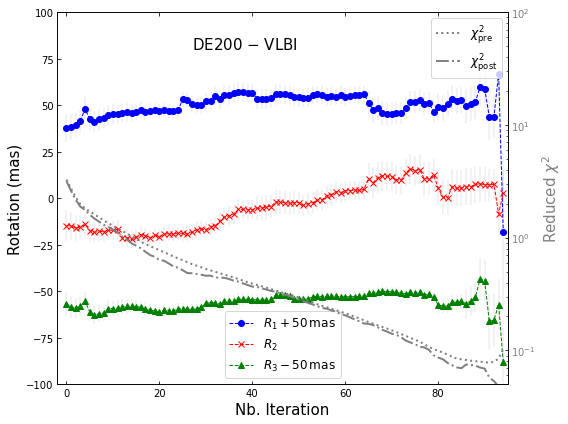

In [28]:
rot_vs_iter(
    pmt200_a,
    sig200_a,
    [-2, 95, -100, 100],
    elw=0.1,
    add_text=[0.3, 0.9, "DE200 $-$ VLBI"],
    apr_chi2=apr_chi2_200_a,
    pst_chi2=pst_chi2_200_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    ax1_ylim=[0.05, 100],
    caps=0, y_shift=50
)

In [29]:
rot200_a, iqr200_a = find_pmt_est(pmt200_a)

dra_200, ddec_200 = calc_dpos(vlbi_timing200, rot200_a, ref="v")

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(vlbi_timing200, dra_200, ddec_200)

In [30]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200[0], iqr200[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200[1], iqr200[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200[2], iqr200[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[0], iqr200_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[1], iqr200_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[2], iqr200_a[2]))

Using all samples, the rotation parameters are
R1:       1 +/-      6 mas
R2:      -4 +/-      4 mas
R3:      -5 +/-      4 mas
After removing outliers, the rotation parameters are
R1:       1 +/-      6 mas
R2:      -3 +/-      4 mas
R3:      -5 +/-      4 mas


## 2.2 DE405 vs VLBI

In [31]:
mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

nb_psr_405 = len(vlbi_timing405.group_by("psr_name").groups)
nb_obs_405 = len(vlbi_timing405)

count_psr_nb(vlbi_timing405)
# vlbi_timing405

There are 9 pulsars with 9 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:662: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


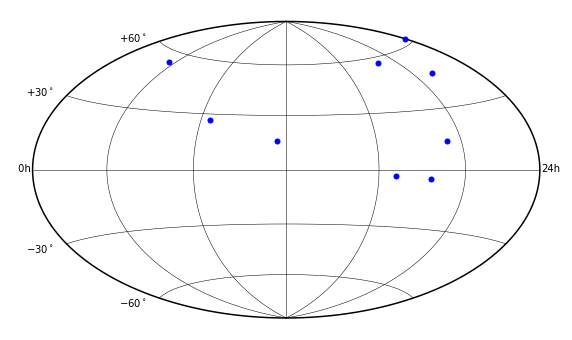

In [32]:
sou_dist_plot(vlbi_timing405["ra_v"], vlbi_timing405["dec_v"])

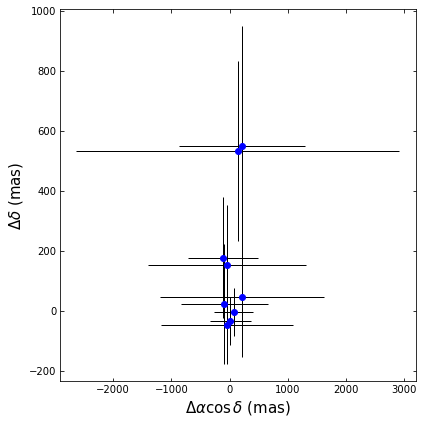

In [33]:
simple_plot(vlbi_timing405)

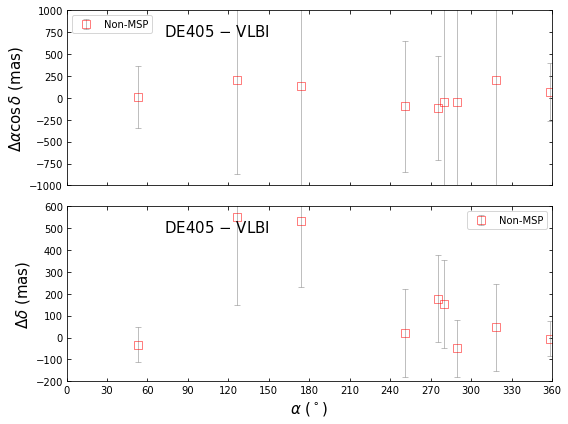

In [34]:
pos_oft_vs_coord(
    vlbi_timing405,
    [-1000, 1000, -200, 600],
    vlbi_timing405["dra"],
    vlbi_timing405["ddec"],
    add_text=[0.2, 0.85, "DE405 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

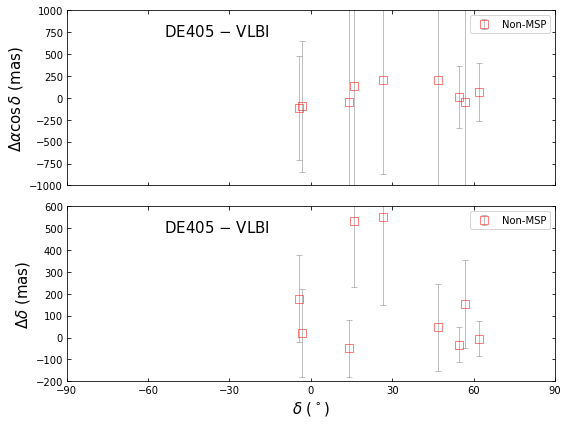

In [35]:
pos_oft_vs_coord(
    vlbi_timing405,
    [-1000, 1000, -200, 600],
    vlbi_timing405["dra"],
    vlbi_timing405["ddec"],
    add_text=[0.2, 0.85, "DE405 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

In [36]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(
    vlbi_timing405, ref="v")

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  9      0.5      0.4     -26.88      39.70       0.31 J1136+1551    52398      2.7
 2  8      0.3      0.3     -32.89      16.10     -10.96 J0826+2637    52398      2.0
 3  7      0.2      0.1     -47.20       4.97     -39.66 J1820-0427    52196      0.4
 4  6      0.1      0.1     -30.33       9.45       2.27 J1840+5640    52285      0.4
 5  5      0.1      0.1     -12.74      15.42      21.73 J0332+5434    52337      0.0
 6  4      0.1      0.1       9.46       4.91      41.58 J1917+1353    52298      0.1
 7  3      0.1      0.0     -45.87       3.46       3.56 J2113+4644    52284      0.0


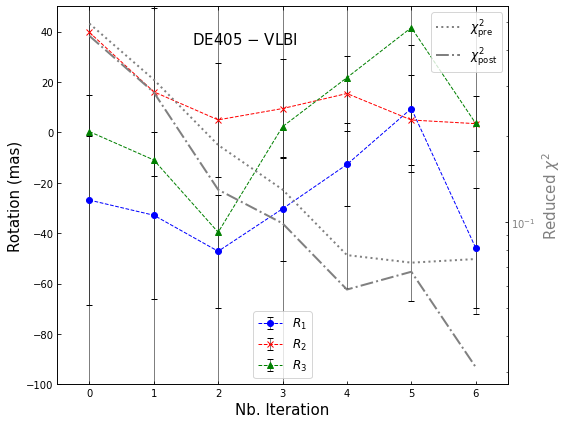

In [37]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 6.5, -100, 50],
    add_text=[0.3, 0.9, "DE405 $-$ VLBI"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5
)

In [38]:
rot405, iqr405 = find_pmt_est(pmt405)

dra_405, ddec_405 = calc_dpos(vlbi_timing405, rot405, ref="v")

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(vlbi_timing405, dra_405, ddec_405)

## 1.3 DE421 vs VLBI

In [39]:
mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

nb_psr_421 = len(vlbi_timing421.group_by("psr_name").groups)
nb_obs_421 = len(vlbi_timing421)

count_psr_nb(vlbi_timing421)
# vlbi_timing421

There are 16 pulsars with 18 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:662: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


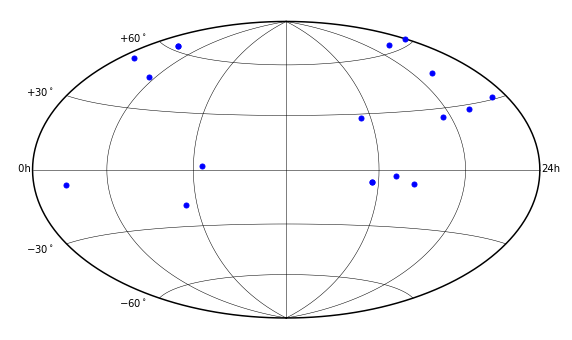

In [40]:
sou_dist_plot(vlbi_timing421["ra_v"], vlbi_timing421["dec_v"])

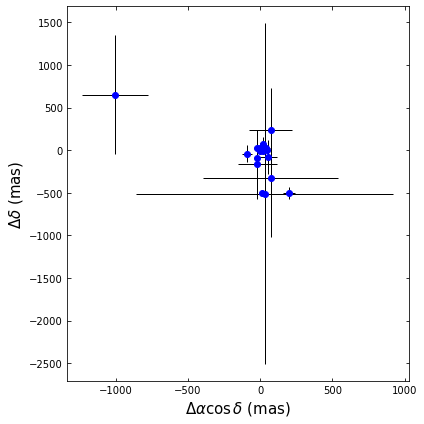

In [41]:
simple_plot(vlbi_timing421)

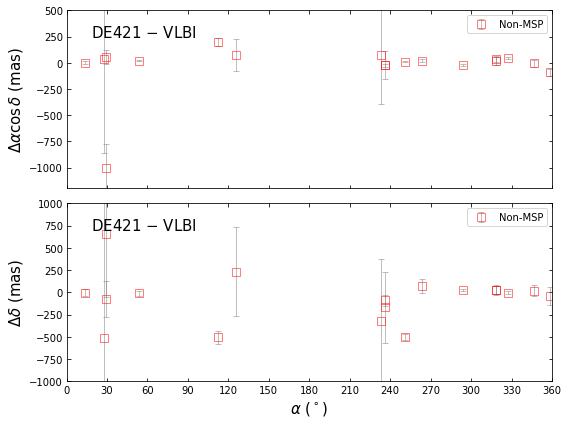

In [42]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-1200, 500, -1000, 1000],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    add_text=[0.05, 0.85, "DE421 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

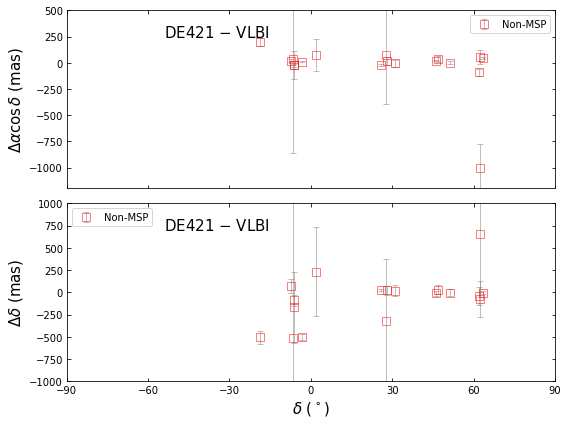

In [43]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-1200, 500, -1000, 1000],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    ref="v",
    xaxis="dec",
    add_text=[0.2, 0.85, "DE421 $-$ VLBI"],
    divided=True,
)

In [44]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    vlbi_timing421, ref="v")

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 16     13.7     13.3      -2.37     -16.27      10.96 J1645-0317    56000    274.4
 2 15      5.3      4.4     -34.46       0.63      -2.63 J0729-1836    56000     70.0
 3 14      2.9      2.2     -31.38      -0.29      -4.85 J2149+6329    54595      8.0
 4 13      2.2      1.7      -7.29     -29.99      -5.12 J0157+6212    56000     20.7
 5 13      1.6      1.0      -8.22     -30.06      -5.15 J1937+2544    54248      0.4
 6 12      1.3      1.0      -4.04     -21.37       2.55 J0335+4555    54596      1.1
 7 11      1.0      1.0       9.17      -1.92       1.45 J2354+6155    56000      6.7
 8 10      0.6      0.6     -12.49      -1.50      -1.01 J1543-0620    54601      5.3
 9 10      0.4      0.3      -9.04       2.86      14.14 J1735-0724    54602      0.6
10  9      0.3      0.2     -19.29       7.97      -0.38 J2113+4644    53915      0.9
11  8      0.2      0.2      -6.08      -3.56       2.

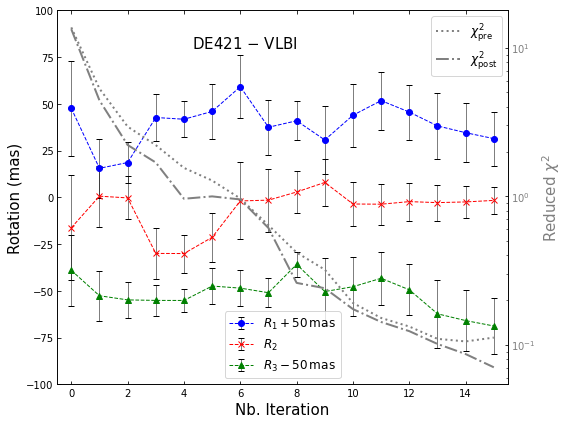

In [45]:
rot_vs_iter(pmt421, sig421, [-0.5, 15.5, -100, 100],
            elw=0.5,
            add_text=[0.3, 0.9, "DE421 $-$ VLBI"],
            apr_chi2=apr_chi2_421,
            pst_chi2=pst_chi2_421,
            ax_loc="lower center",
            ax1_loc="upper right",
            y_shift=50)

In [46]:
rot421, iqr421 = find_pmt_est(pmt421)

dra_421, ddec_421 = calc_dpos(vlbi_timing421, rot421, ref="v")

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(vlbi_timing421, dra_421, ddec_421)

In [47]:
mask = (
    (np.fabs(vlbi_timing421["dra"]) < 1000)
    & (np.fabs(vlbi_timing421["ddec"]) < 1000)
)

vlbi_timing421_a = vlbi_timing421[mask]

In [48]:
pmt421_a, sig421_a, indx, apr_chi2_421_a, pst_chi2_421_a = rot_fit_4_table(
    vlbi_timing421_a, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 16     13.9     13.5      -2.93     -16.58      10.96 J1645-0317    56000    274.8
 2 15      5.0      4.0     -35.06       0.33      -2.64 J0729-1836    56000     69.9
 3 14      2.4      1.6     -31.98      -0.59      -4.86 J2149+6329    54595      7.9
 4 13      1.6      1.0      -8.22     -30.06      -5.15 J1937+2544    54248      0.4
 5 12      1.3      1.0      -4.04     -21.37       2.55 J0335+4555    54596      1.1
 6 11      1.0      1.0       9.17      -1.92       1.45 J2354+6155    56000      6.7
 7 10      0.6      0.6     -12.49      -1.50      -1.01 J1543-0620    54601      5.3
 8 10      0.4      0.3      -9.04       2.86      14.14 J1735-0724    54602      0.6
 9  9      0.3      0.2     -19.29       7.97      -0.38 J2113+4644    53915      0.9
10  8      0.2      0.2      -6.08      -3.56       2.20 J0157+6212    54594      0.6
11  7      0.2      0.1       1.75      -3.66       6.

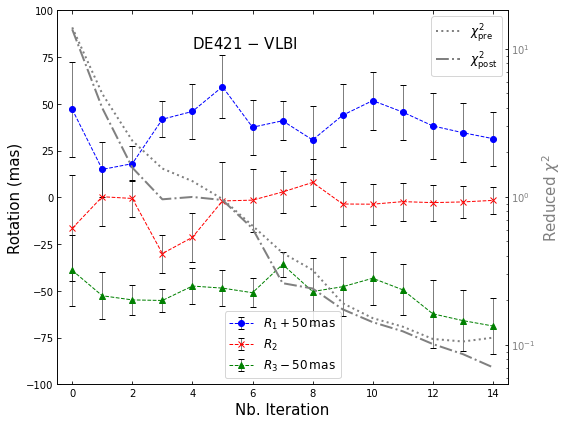

In [49]:
rot_vs_iter(
    pmt421_a,
    sig421_a,
    [-0.5, 14.5, -100, 100],
    xaxis_range=np.arange(0, 15, 2),
    elw=0.5,
    add_text=[0.3, 0.9, "DE421 $-$ VLBI"],
    apr_chi2=apr_chi2_421_a,
    pst_chi2=pst_chi2_421_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50
)

In [50]:
rot421_a, iqr421_a = find_pmt_est(pmt421_a)

dra_421, ddec_421 = calc_dpos(vlbi_timing421, rot421_a, ref="v")

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(vlbi_timing421, dra_421, ddec_421)

In [51]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot421[0], iqr421[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot421[1], iqr421[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot421[2], iqr421[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot421_a[0], iqr421_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot421_a[1], iqr421_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot421_a[2], iqr421_a[2]))

Using all samples, the rotation parameters are
R1:      -9 +/-      9 mas
R2:      -2 +/-      5 mas
R3:      -1 +/-      5 mas
After removing outliers, the rotation parameters are
R1:      -9 +/-      9 mas
R2:      -2 +/-      5 mas
R3:      -0 +/-      5 mas


## 2.4 DE430 vs VLBI

In [52]:
mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

nb_psr_430 = len(vlbi_timing430.group_by("psr_name").groups)
nb_obs_430 = len(vlbi_timing430)

count_psr_nb(vlbi_timing430)
# vlbi_timing430

There are 17 pulsars with 28 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:662: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


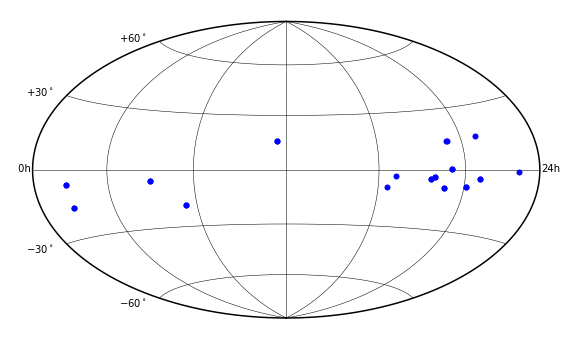

In [53]:
sou_dist_plot(vlbi_timing430["ra_v"], vlbi_timing430["dec_v"])

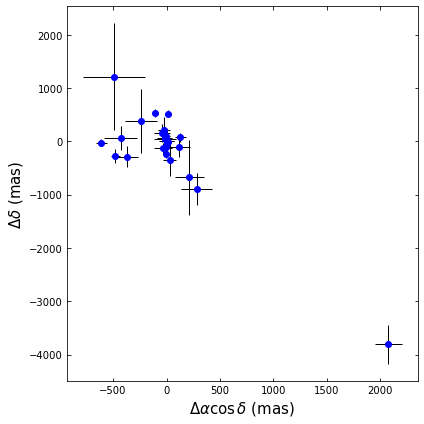

In [54]:
simple_plot(vlbi_timing430)

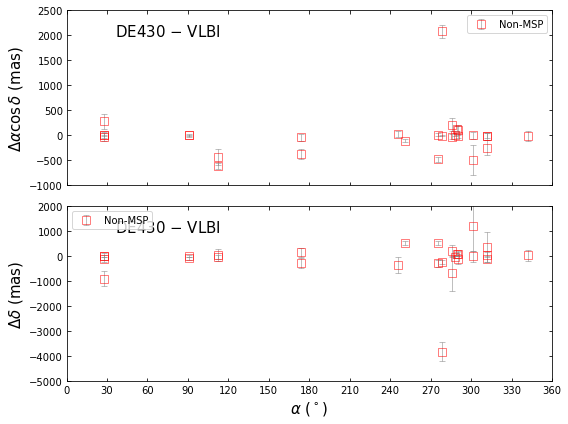

In [55]:
pos_oft_vs_coord(
    vlbi_timing430,
    [-1000, 2500, -5000, 2000],
    vlbi_timing430["dra"],
    vlbi_timing430["ddec"],
    #     fig_name="vlbi_pos-oft-vs-ra-de430.eps",
    add_text=[0.1, 0.85, "DE430 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

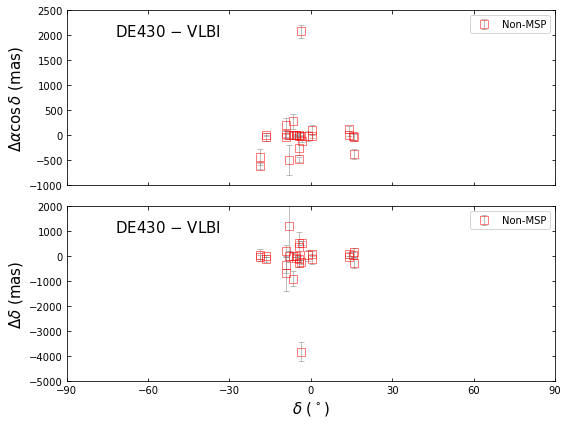

In [56]:
pos_oft_vs_coord(
    vlbi_timing430,
    [-1000, 2500, -5000, 2000],
    vlbi_timing430["dra"],
    vlbi_timing430["ddec"],
    #     fig_name="vlbi_pos-oft-vs-dec-de430.eps",
    add_text=[0.1, 0.85, "DE430 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

In [57]:
pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
    vlbi_timing430, ref="v")

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 17     16.0     15.8     -24.13      20.87     -17.82 J1833-0338    57600    393.4
 2 17      8.9      8.6     -30.46      29.64     -24.04 J0729-1836    57600    123.5
 3 17      6.6      6.3     -39.62      68.54     -16.82 J1820-0427    57600    115.8
 4 17      4.2      3.9     -46.35      44.14      -4.22 J1645-0317    57600     46.6
 5 16      3.1      3.0     -27.50      15.32       2.10 J1820-0427    57600     50.4
 6 15      1.9      1.9       4.21      22.96      -0.50 J1136+1551    57600     16.7
 7 15      1.6      1.5       7.19      26.24       1.05 J0151-0635    57600     12.0
 8 15      1.3      1.3       8.48      19.47       0.78 J1833-0338    57600     10.6
 9 14      1.1      1.1      -7.39       9.69       4.36 J0729-1836    57600      8.5
10 13      0.9      0.9      -8.89      12.58       5.35 J1917+1353    57600      7.0
11 12      0.7      0.7      -2.78      10.08       1.

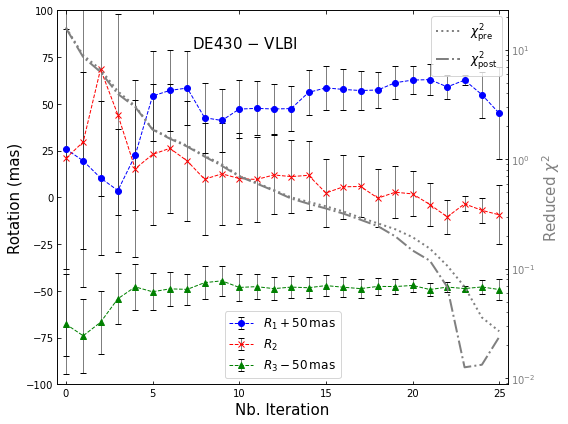

In [58]:
rot_vs_iter(
    pmt430,
    sig430,
    [-0.5, 25.5, -100, 100],
    add_text=[0.3, 0.9, "DE430 $-$ VLBI"],
    apr_chi2=apr_chi2_430,
    pst_chi2=pst_chi2_430,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=50
)

In [59]:
rot430, iqr430 = find_pmt_est(pmt430)

dra_430, ddec_430 = calc_dpos(vlbi_timing430, rot430, ref="v")

a_chi2_430, p_chi2_430 = calc_chi2_4_fit(vlbi_timing430, dra_430, ddec_430)

In [60]:
mask = (
    (np.fabs(vlbi_timing430["dra"]) < 1000)
    & (np.fabs(vlbi_timing430["ddec"]) < 1000)
)

vlbi_timing430_a = vlbi_timing430[mask]

nb_psr_430 = len(vlbi_timing430_a.group_by("psr_name").groups)
nb_obs_430 = len(vlbi_timing430_a)

print("When removing the outlier, we have", nb_psr_430,
      "pulsars in the sample from DE430 vs. PSRPI comparison with",
      nb_obs_430, "observations.")
# vlbi_timing430_a

When removing the outlier, we have 17 pulsars in the sample from DE430 vs. PSRPI comparison with 26 observations.


In [61]:
pmt430_a, sig430_a, indx, apr_chi2_430_a, pst_chi2_430_a = rot_fit_4_table(
    vlbi_timing430_a, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 17      9.2      8.8     -30.13      29.41     -23.81 J0729-1836    57600    123.6
 2 17      6.8      6.5     -39.29      68.33     -16.59 J1820-0427    57600    115.9
 3 17      4.3      4.0     -46.01      43.89      -3.97 J1645-0317    57600     46.7
 4 16      3.1      3.0     -27.15      15.01       2.38 J1820-0427    57600     50.4
 5 15      1.9      1.9       4.59      22.63      -0.22 J1136+1551    57600     16.7
 6 15      1.5      1.5       7.58      25.91       1.34 J0151-0635    57600     12.0
 7 15      1.3      1.3       8.86      19.13       1.07 J1833-0338    57600     10.6
 8 14      1.0      1.0      -7.01       9.15       4.77 J0729-1836    57600      8.5
 9 13      0.8      0.8      -8.51      12.03       5.76 J1917+1353    57600      7.0
10 12      0.6      0.6      -2.40       9.56       2.23 J1901-0906    57600      3.6
11 12      0.5      0.5      -2.73      11.98       1.

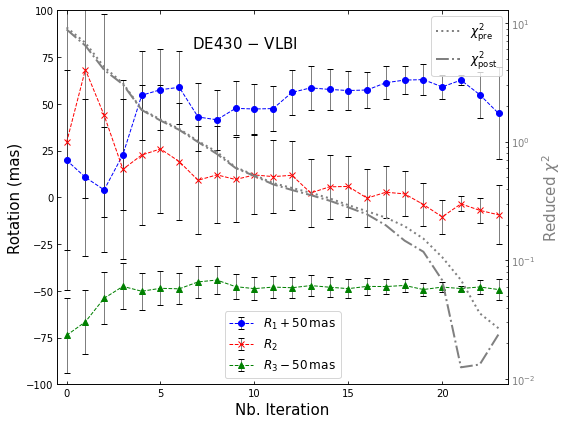

In [62]:
rot_vs_iter(
    pmt430_a,
    sig430_a,
    [-0.5, 23.5, -100, 100],
    elw=0.5,
    add_text=[0.3, 0.9, "DE430 $-$ VLBI"],
    apr_chi2=apr_chi2_430_a,
    pst_chi2=pst_chi2_430_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50
)

In [63]:
rot430_a, iqr430_a = find_pmt_est(pmt430_a)

dra_430, ddec_430 = calc_dpos(vlbi_timing430, rot430_a, ref="v")

a_chi2_430, p_chi2_430 = calc_chi2_4_fit(vlbi_timing430, dra_430, ddec_430)

In [64]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot430[0], iqr430[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot430[1], iqr430[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot430[2], iqr430[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot430_a[0], iqr430_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot430_a[1], iqr430_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot430_a[2], iqr430_a[2]))

Using all samples, the rotation parameters are
R1:       5 +/-     11 mas
R2:      10 +/-      1 mas
R3:       2 +/-      1 mas
After removing outliers, the rotation parameters are
R1:       6 +/-     11 mas
R2:       9 +/-      1 mas
R3:       2 +/-      1 mas


## 2.5 DE436 vs VLBI

In [65]:
mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

# nb_psr_436 = len(vlbi_timing436.group_by("psr_name").groups)
# nb_obs_436 = len(vlbi_timing436)

vlbi_timing436

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


# 3 Summary

In [66]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_v", "dec_err_v", "pos_err_v"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and VLBI positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"])

print(tbl)

Positional formal uncertainty for timing and VLBI positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_v dec_err_v pos_err_v
---------------------------------------------------------------
DE200    59.99    150.00    166.86     1.44      1.00      1.77
DE405  1078.91    200.00   1138.20     1.34      1.00      1.67
DE421    34.18     75.00     81.09     1.34      1.00      1.69
DE430    70.74    200.00    222.35     1.50      2.00      2.50
DE436      nan       nan       nan      nan       nan       nan
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [67]:
mydata = [[nb_psr_200, nb_obs_200,
           rot200_a[0], iqr200_a[0], rot200_a[1], iqr200_a[1], rot200_a[2], iqr200_a[2],
          a_chi2_200, p_chi2_200],
          [nb_psr_405, nb_obs_405,
           rot405[0], iqr405[0], rot405[1], iqr405[1], rot405[2], iqr405[2],
           a_chi2_405, p_chi2_405],
          [nb_psr_421, nb_obs_421,
           rot421_a[0], iqr421_a[0], rot421_a[1], iqr421_a[1], rot421_a[2], iqr421_a[2],
           a_chi2_421, p_chi2_421],
          [nb_psr_430, nb_obs_430,
           rot430_a[0], iqr430_a[0], rot430_a[1], iqr430_a[1], rot430_a[2], iqr430_a[2],
           a_chi2_430, p_chi2_430]]

myheaders = ["Nb.PSR", "Nb.Obs", "R1", "R1_err", "R2", "R2_err", "R3", "R3_err",
             "ApreFitChi2", "PostFitChi2"]
mystubs = ["DE200", "DE405", "DE421", "DE430"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. VLBI frame (mas)",
    data_fmts=["%d", "%d", "%6.1f", "%6.1f", "%6.1f", "%6.1f", "%6.1f", "%6.1f",
               "%6.2f", "%6.2f"])

print(tbl)

                    Orientation of DE frame wrt. VLBI frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200     51     97    1.4    6.0   -2.9   16.6   -5.1    4.4  1535612.46  1535612.77
DE405      9      9  -30.3   14.5    9.5    8.0    2.3   13.3        0.41        0.38
DE421     16     18   -9.0    9.5   -2.3    1.9   -0.4    5.5       12.53       12.42
DE430     17     26    5.5   10.5    9.4   10.9    1.8    1.0       15.14       15.20
-------------------------------------------------------------------------------------
